# imports

In [ ]:
pip install pyvis

In [ ]:
import pandas as pd
from ast import literal_eval
import networkx as nx
import pylab as plt
from pyvis import network as net
from networkx.algorithms import community
import pickle

# AUX

In [ ]:
def FindMaxLength(lst):
    maxList = max(lst, key = lambda i: len(i))
    maxLength = len(maxList)
    return maxLength
def FindMinLength(lst):
    maxList = min(lst, key = lambda i: len(i))
    maxLength = len(maxList)
    return maxLength

In [ ]:
def make_pairs(lst):
    pairs = []
    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):
            pairs.append([lst[i], lst[j]])
    return pairs

def check_subset(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return set1.issubset(set2)

def check_value_not_in_list_of_dicts(lst, key, value):
    for dictionary in lst:
        if key in dictionary and dictionary[key] == value:
            return False
    return True

def simplify_list(lst):
    simplified = []
    for sublist in lst:
        found = False
        for s in simplified:
            if any(item in s for item in sublist):
                s.extend(item for item in sublist if item not in s)
                found = True
                break
        if not found:
            simplified.append(sublist)
    return simplified

def extract_common_pairs(list_of_lists):
    common_pairs = []
    for i in range(len(list_of_lists)):
      sub_list1 = list_of_lists[i]
      pairs = make_pairs(sub_list1)
      # print(pairs)
      pair_is_repeated = False
      for j in range(len(list_of_lists)):
          if i != j:
            sub_list2 = list_of_lists[j]
            pairs2 = make_pairs(sub_list2)
            # print(pairs2)
            for pair in pairs:
              if pair in pairs2:
                pair_is_repeated = True
                if pair not in common_pairs:
                  common_pairs.append(pair)


      # print("#######################################")
    return common_pairs

In [ ]:
def get_res(path, save_vis, data_name):
  df = pd.read_csv(path)
  df["feature_list"] = df["feature_list"].apply(literal_eval)
  print("There are " + str(len(df)) +" actions in " + str(data_name))
  max_num_feature = FindMaxLength(list(df["feature_list"]))
  min_num_feature = FindMinLength(list(df["feature_list"]))
  print("The max number of feature an action posses: " + str(max_num_feature))
  print("The min number of feature an action posses: " + str(min_num_feature))
  print("##############################")
  G = nx.Graph()
  for i in range(len(df.index)):
      action = df["Action Name"][i]
      features = df["feature_list"][i]
      G.add_node(action, label = action, shape="diamond", color="green")
      for feature in features:
          G.add_node(feature, label = feature, shape = "triangle" , color = "blue")
          G.add_edge(action, feature, color="green" )
  print("Created feature network")
  print("##############################")
  components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
  print("There are " + str(len(components)) + " disjoint/ connected components in feature network")
  print("##############################")
  options = {
    "interaction": {
    "navigationButtons": True
    },
    "stabilization":{
        "enabled": True,
        "iterations": 800
      }
  }
  pickle.dump(G, open(save_vis + "/" +data_name+"_network1.pickle", 'wb'))
  G2 = net.Network(notebook=True)
  G2.options = options
  G2.from_nx(G)
  G2.show(save_vis + "/" +data_name+"1.html")
  print("Saved pvis visualization 1")
  print("##############################")
  print("10 most important features")
  degree_centrality = nx.degree_centrality(G)
  count = 10
  for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True):
    if count > 0:
      print(node, degree_centrality[node])
      count = count -1
  print("##############################")
  print("distribution of degrees")
  degrees = [G.degree(n) for n in G.nodes()]
  plt.hist(degrees)
  print("##############################")
  nodes_with_degree_2_or_more = [(node, degree) for node, degree in dict(G.degree()).items() if degree >= 0]
  df_features = pd.DataFrame(nodes_with_degree_2_or_more, columns=['Features', 'Degree'])
  nodes_with_degree_2_or_more = [(node, degree) for node, degree in dict(G.degree()).items() if degree >= 2]
  df_degree2 = pd.DataFrame(nodes_with_degree_2_or_more, columns=['nodes', 'Degree'])
  is_unique = len(set(list(df_features["Features"]))) ==len(list(df_features["Features"]))
  print("The nodes are unique: " + str(is_unique))
  print("There are " + str(len(list(df_degree2["nodes"]))) + "  nodes with degree 2 or more")
  # are all node features?
  action_names = list(df["Action Name"])
  nodes = list(df_degree2["nodes"])
  actions_with_degree2 = []; features_with_degree2 = []
  for n in nodes:
    if n in action_names:
      actions_with_degree2.append(n)
    else:
      features_with_degree2.append(n)

  if len(actions_with_degree2) != 0:
    print("not all nodes are features")
    print("number of actions with degree 2 or higher:  " + str(len(actions_with_degree2)))
    print("number of features with degree 2 or higher:  " + str(len(features_with_degree2)))

  df_degree_2 = df.copy()
  for index, row in df_degree_2.iterrows():
      features = row['feature_list']
      keep = False
      for f in features_with_degree2:
        if f in features:
          keep  = True
      if not keep:
          df_degree_2 = df_degree_2.drop(index)
  df_degree_2 = df_degree_2.reset_index(drop=True)
  print("There are " + str(len(df_degree_2)) + " actions with features of degree 2 or higher")
  print("##############################")
  print("Adding publishers to the network")
  G_degree_2 = nx.Graph()
  for i in range(len(df_degree_2.index)):
      action = df_degree_2["Action Name"][i]
      features = df_degree_2["feature_list"][i]
      publisher = df_degree_2["publisher"][i]
      G_degree_2.add_node(action, label = action, shape="diamond", color="green")
      G_degree_2.add_node(publisher, label = publisher, shape="dot", color="red")
      G_degree_2.add_edge(action, publisher, color = "red")
      # add features that connected to at least another action
      for f in features:
        feature_repeated = False
        for j in range(len(df_degree_2.index)):
          if i != j:
            features2 = df_degree_2["feature_list"][j]
            if f in features2:
              feature_repeated = True
              break
        if feature_repeated:
          G_degree_2.add_node(f, label = f, shape = "triangle" , color = "blue")
          G_degree_2.add_edge(action, f, color = "green")
  print("Finished adding publishers")
  print("##############################")
  components = [G_degree_2.subgraph(c).copy() for c in nx.connected_components(G_degree_2)]
  print("There are " + str(len(components)) + " disjoint/ connected components in feature with degree 2 or higher network")
  print("##############################")
  pickle.dump(G_degree_2, open(save_vis + "/" +data_name+"_network2.pickle", 'wb'))
  G2 = net.Network(notebook=True)
  G2.options = options
  G2.from_nx(G_degree_2)
  G2.show(save_vis + "/" +data_name+"2.html")
  print("Saved pvis visualization 2")
  print("##############################")
  action_has_same_publisher = []; already_checked = []
  for i in range(len(df_degree_2.index)):
      action = df_degree_2["Action Name"][i]
      features = df_degree_2["feature_list"][i]
      publisher = df_degree_2["publisher"][i]
      # add features that connected to at least another action
      for f in features:
        feature_repeated = False
        for j in range(len(df_degree_2.index)):
          if i != j:
            action2 = df_degree_2["Action Name"][j]
            features2 = df_degree_2["feature_list"][j]
            publisher2 = df_degree_2["publisher"][j]
            if f in features2 and publisher==publisher2 :
              action_has_same_publisher.append(action)
  df_pub = df_degree_2.copy() ; keep_actions = list(set(action_has_same_publisher))
  for index, row in df_pub.iterrows():
      action = row['Action Name']
      if action not in keep_actions:
          df_pub = df_pub.drop(index)
  df_pub = df_pub.reset_index(drop=True)
  print("There are " + str(len(df_pub)) + " actions with at least one common feature and publishier with other actions")
  print("##############################")
  print("Refining the publisher network")
  G_pub = nx.Graph()
  for i in range(len(df_pub.index)):
      action = df_pub["Action Name"][i]
      features = df_pub["feature_list"][i]
      publisher = df_pub["publisher"][i]
      G_pub.add_node(action, label = action, shape="diamond", color="green")
      G_pub.add_node(publisher, label = publisher, shape="dot", color="red")
      G_pub.add_edge(action, publisher, color = "red")
      # add features that connected to at least another action
      for f in features:
        feature_repeated = False
        for j in range(len(df_pub.index)):
          if i != j:
            features2 = df_pub["feature_list"][j]
            if f in features2:
              feature_repeated = True
              break
        if feature_repeated:
          G_pub.add_node(f, label = f, shape = "triangle" , color = "blue")
          G_pub.add_edge(action, f, color = "green")
  pickle.dump(G_pub, open(save_vis + "/" +data_name+"_network3.pickle", 'wb'))
  print("##############################")
  components = [G_pub.subgraph(c).copy() for c in nx.connected_components(G_pub)]
  print("There are " + str(len(components)) + " disjoint/ connected components in actions with at least one common feature and shared publisher network")
  print("##############################")
  G2 = net.Network(notebook=True)
  G2.options = options
  G2.from_nx(G_pub)
  G2.show(save_vis + "/" +data_name+"3.html")
  print("Saved pvis visualization 3")
  print("##############################")



In [ ]:
def get_res_test(path, save_vis, data_name, cat_name):
  file_path = save_vis+"/"+cat_name+"_report.txt"
  with open(file_path, "w") as f:
    f.write("Category: " + cat_name +"\n")
  df = pd.read_csv(path)
  df["feature_list"] = df["feature_list"].apply(literal_eval)
  print("There are " + str(len(df)) +" actions in " + str(data_name))
  max_num_feature = FindMaxLength(list(df["feature_list"]))
  min_num_feature = FindMinLength(list(df["feature_list"]))
  print("The max number of feature an action posses: " + str(max_num_feature))
  print("The min number of feature an action posses: " + str(min_num_feature))
  print("##############################")
  with open(file_path, "a") as f:
    f.write("The max number of feature an action posses: " + str(max_num_feature) +"\n")
    f.write("The min number of feature an action posses: " + str(min_num_feature) +"\n")
  ################################################################################
  G = nx.Graph()
  for i in range(len(df.index)):
      action = df["Action Name"][i]
      features = df["feature_list"][i]
      G.add_node(action, label = action, shape="diamond", color="green")
      publisher = df["publisher"][i]
      G.add_node(publisher, label = publisher, shape="dot", color="red")
      G.add_edge(action, publisher, color = "red")
      for feature in features:
          G.add_node(feature, label = feature, shape = "triangle" , color = "blue")
          G.add_edge(action, feature, color="green" )
  print("Created feature network")
  print("##############################")
  components = [G.subgraph(c).copy() for c in nx.connected_components(G)]
  print("There are " + str(len(components)) + " disjoint/ connected components in feature network")
  with open(file_path, "a") as f:
    f.write("There are " + str(len(components)) + " disjoint/ connected components in feature network-- objectives of the category"+"\n")
  print("##############################")
  ##################################################################################
  options = {
    "interaction": {
    "navigationButtons": True
    },
    "stabilization":{
        "enabled": True,
        "iterations": 800
      }
  }
  ##################################################################################
#   print("Saving feature network + visualization")
#   pickle.dump(G, open(save_vis + "/" +data_name+"_feature_net.pickle", 'wb'))
#   G2 = net.Network(notebook=True)
#   G2.options = options
#   G2.from_nx(G)
#   G2.show(save_vis + "/" +data_name+"_feature_net.html")
#   print("Saved pvis visualization: feature_net")
#   print("##############################")
  ###################################################################################
  print("10 most important features")
  with open(file_path, "a") as f:
    f.write("10 most important features: " + "\n")
  degree_centrality = nx.degree_centrality(G)
  count = 10
  for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True):
    if count > 0:
      print(node, degree_centrality[node])
      with open(file_path, "a") as f:
        f.write(str(count) + ". "+ str(node) + "|" + str(degree_centrality[node]) +"\n")
      count = count -1
  print("##############################")
  print("distribution of degrees")
  degrees = [G.degree(n) for n in G.nodes()]
#   plt.hist(degrees)
  print("##############################")
  ###################################################################################
  all_nodes = [(node, degree) for node, degree in dict(G.degree()).items() if degree >= 0]
  df_features = pd.DataFrame(all_nodes, columns=['Features', 'Degree'])
  is_unique = len(set(list(df_features["Features"]))) ==len(list(df_features["Features"]))
  print("All nodes are unique: " + str(is_unique))
  with open(file_path, "a") as f:
    f.write("All nodes are unique: " + str(is_unique) + "\n")
  ###################################################################################
  action_names = list(df["Action Name"])
  node_with_degree_one = [(node, degree) for node, degree in dict(G.degree()).items() if degree < 2]
  degree_1_nodes = pd.DataFrame(node_with_degree_one, columns=['nodes', 'Degree'])
  nodes = list(degree_1_nodes["nodes"])
  actions_with_degree1 = []; feature_with_degree_1=[]
  for n in nodes:
    if n in action_names:
      actions_with_degree1.append(n)
    else:
      feature_with_degree_1.append(n)
  if len(actions_with_degree1) != 0:
    print("number of actions with degree 1 or higher:  " + str(len(actions_with_degree1)))
    with open(file_path, "a") as f:
      f.write("number of actions with degree 1 or higher (actions with only one feature):  " + str(len(actions_with_degree1))+"\n")
    print("number of features with degree 1 or higher:  " + str(len(feature_with_degree_1)))
    with open(file_path, "a") as f:
      f.write("number of features with degree 1 or higher(features that belong to only one action):  " + str(len(feature_with_degree_1))+"\n")
  ###################################################################################
  # Find atomic actions: if an actions has all feature that's in feature_with_degree_1 it means that is the only action with this feature
  # hence it is atomic action
  df_atomic_Actions = df.copy()
  for index, row in df_atomic_Actions.iterrows():
      features = row['feature_list']
      found_unique_feature = False
      for feature in features:
        if feature in feature_with_degree_1:
          found_unique_feature = True
        else:
          found_unique_feature = False
          break
      if not found_unique_feature:
        df_atomic_Actions = df_atomic_Actions.drop(index)
  df_atomic_Actions = df_atomic_Actions.reset_index(drop=True)
  print("There are " + str(len(df_atomic_Actions)) + " Atomic Actions.")
  with open(file_path, "a") as f:
    f.write("There are " + str(len(df_atomic_Actions)) + " Atomic Actions working on unique objectives." + "\n")
  print("##############################")
  #Add publisher to find atomic publishers
  print("adding publisher to atomic network")
  G_degree_1 = nx.Graph()
  for i in range(len(df_atomic_Actions.index)):
      action = df_atomic_Actions["Action Name"][i]
      features = df_atomic_Actions["feature_list"][i]
      publisher = df_atomic_Actions["publisher"][i]
      G_degree_1.add_node(action, label = action, shape="diamond", color="green")
      G_degree_1.add_node(publisher, label = publisher, shape="dot", color="red")
      G_degree_1.add_edge(action, publisher, color = "red")
      # add features that connected to at least another action
      for f in features:
          G_degree_1.add_node(f, label = f, shape = "triangle" , color = "blue")
          G_degree_1.add_edge(action, f, color = "green")
  print("Finished adding publishers")
  print("##############################")
  ###################################################################################
#   print("creating pyvis")
#   pickle.dump(G_degree_1, open(save_vis + "/" +data_name+"_atomic_publisher.pickle", 'wb'))
#   G2 = net.Network(notebook=True)
#   G2.options = options
#   G2.from_nx(G_degree_1)
#   G2.show(save_vis + "/" +data_name+"_atomic_publisher.html")
#   print("Saved pvis visualization: atomic_publisher")
#   print("##############################")
  ###################################################################################
  components = [G_degree_1.subgraph(c).copy() for c in nx.connected_components(G_degree_1)]
  print("There are " + str(len(components)) + " atomic publishers working on one or more atomic actions")
  with open(file_path, "a") as f:
    f.write("There are " + str(len(components)) + " atomic publishers working on one or more atomic actions" + "\n")
  print("##############################")
  ###################################################################################
  nodes_with_degree_2_or_more = [(node, degree) for node, degree in dict(G.degree()).items() if degree >= 2]
  df_degree2 = pd.DataFrame(nodes_with_degree_2_or_more, columns=['nodes', 'Degree'])
  print("There are " + str(len(list(df_degree2["nodes"]))) + "  nodes with degree 2 or more")
  with open(file_path, "a") as f:
    f.write("There are " + str(len(list(df_degree2["nodes"]))) + "  nodes with degree 2 or more" + "\n")
  # are all node features?
  nodes = list(df_degree2["nodes"])
  actions_with_degree2 = []; features_with_degree2 = []
  for n in nodes:
    if n in action_names:
      actions_with_degree2.append(n)
    else:
      features_with_degree2.append(n)
  if len(actions_with_degree2) != 0:
    print("not all nodes are features")
    print("number of actions with degree 2 or higher:  " + str(len(actions_with_degree2)))
    with open(file_path, "a") as f:
      f.write("number of actions with degree 2 or higher (actions with at least 2 features):  " + str(len(actions_with_degree2)) +"\n")
    print("number of features with degree 2 or higher:  " + str(len(features_with_degree2)))
    with open(file_path, "a") as f:
      f.write("number of features with degree 2 or higher (features common between at least 2 actions):  " + str(len(features_with_degree2))+"\n")
  ###################################################################################
  #Find composite Actions
  df_degree_2 = df.copy()
  for index, row in df_degree_2.iterrows():
      features = row['feature_list']
      keep = False
      for f in features_with_degree2:
        if f in features:
          keep  = True
          break
      if not keep:
          df_degree_2 = df_degree_2.drop(index)
  df_degree_2 = df_degree_2.reset_index(drop=True)
  print("There are " + str(len(df_degree_2)) + " actions with at least one feature of degree 2 or higher (Composite Actions)")
  with open(file_path, "a") as f:
      f.write("There are " + str(len(df_degree_2)) + " actions with at least one feature in common with at least another actions--composite actions (features of degree 2 or higher)" +"\n")
  print("##############################")
  print("Adding publishers to the network")
  G_degree_2 = nx.Graph()
  for i in range(len(df_degree_2.index)):
      action = df_degree_2["Action Name"][i]
      features = df_degree_2["feature_list"][i]
      publisher = df_degree_2["publisher"][i]
      G_degree_2.add_node(action, label = action, shape="diamond", color="green")
      G_degree_2.add_node(publisher, label = publisher, shape="dot", color="red")
      G_degree_2.add_edge(action, publisher, color = "red")
      # add features that connected to at least another action
      for f in features:
          G_degree_2.add_node(f, label = f, shape = "triangle" , color = "blue")
          G_degree_2.add_edge(action, f, color = "green")
  print("Finished adding publishers")
  print("##############################")
  components = [G_degree_2.subgraph(c).copy() for c in nx.connected_components(G_degree_2)]
  with open(file_path, "a") as f:
    f.write("There are " + str(len(components)) + " objectives targeted by composite publishers" + "\n")
  print("There are " + str(len(components)) + " objectives targeted by composite publishers")
  print("##############################")
  #Find number of composite publishers:
  publisher_list = list(df["publisher"]); action_list =  list(df["Action Name"])
  all = [(node, degree) for node, degree in dict(G_degree_2.degree()).items() if degree >= 0]
  temp_degree2 = pd.DataFrame(all, columns=['nodes', 'Degree'])
  nodes = list(temp_degree2["nodes"])
  publishers= [];
  for n in nodes:
    if n in publisher_list:
      publishers.append(n)
  with open(file_path, "a") as f:
    f.write("There are " + str(len(publishers)) + " composite publishers" + "\n")
  print("There are " + str(len(publishers)) + " composite publishers out of total " + str(len(set(publisher_list))))
  ###########################################################################################
#   pickle.dump(G_degree_2, open(save_vis + "/" +data_name+"_objectives_composite_publisher.pickle", 'wb'))
#   G2 = net.Network(notebook=True)
#   G2.options = options
#   G2.from_nx(G_degree_2)
#   G2.show(save_vis + "/" +data_name+"_objectives_composite_publisher.html")
#   print("Saved pvis visualization 2")
#   print("##############################")
  ###########################################################################
  # Find features that happen together
  all = [(node, degree) for node, degree in dict(G_degree_2.degree()).items() if degree >= 0] # list of tuple of node, degree
  temp_degree2 = pd.DataFrame(all, columns=['nodes', 'Degree'])
  nodes = list(temp_degree2["nodes"]);
  publishers= []; action_list = []; feature_list = []
  publisher_list = list(df["publisher"]); action_list_df =  list(df["Action Name"])
  for n in nodes:
      if n in publisher_list:
        publishers.append(n)
      elif n in action_list_df: action_list.append(n)
      else: feature_list.append(n)

  disjoint_components = list(nx.connected_components(G_degree_2))
  features_that_come_together = []; base_features = []
  for component in disjoint_components:
    subgraph = G_degree_2.subgraph(component)
    edges = list(subgraph.edges())
    edges_action_feature = []
    for e in edges:
        if e[0] not in publishers and e[1] not in publishers:
          edges_action_feature.append(e)
    component_action_list = []; component_feature_list=[]
    for e in edges_action_feature:
      if e[0] in action_list and e[0] not in component_action_list: component_action_list.append(e[0])
      if e[1] in action_list and e[1] not in component_action_list: component_action_list.append(e[1])
      if e[0] not in action_list and e[0] not in component_feature_list: component_feature_list.append(e[0])
      if e[1] not in action_list and e[1] not in component_feature_list: component_feature_list.append(e[1])
    feature_count_action_list = []; action_added=[]
    for action in component_action_list:
      if action not in action_added:
        features = []
        for e in edges_action_feature:
          if e[0] == action and e[1] not in features:
            features.append(e[1])
          if e[1] == action and e[0] not in features:
            features.append(e[0])
        feature_count_action_list.append({"action": action, "features":features })
        action_added.append(action)
    # find features that come together
    list_list_feature = [] ; Find_base_feature_list_fature = []
    for elm in feature_count_action_list:
        feature = elm["features"]
        list_list_feature.append(feature)
        Find_base_feature_list_fature.extend(feature)

    # find the base features of the comoponent
    base_candicate_set_list =list(set(Find_base_feature_list_fature)); base_count_list=[]
    for feature in base_candicate_set_list:
      feature_count = Find_base_feature_list_fature.count(feature)
      base_count_list.append((feature, feature_count))

    num_actions = len(component_action_list);
    for tup in base_count_list:
      if tup[1] == num_actions and num_actions> 2 : base_features.append(tup[0])
    # features_pair_come_together = extract_common_pairs(list_list_feature)

    # print(features_pair_come_together)
    # check if the pairs are repeated
  #   repeated_pairs = []
  #   for i in range(len(features_pair_come_together)):
  #     repeat_count = 0
  #     pair = features_pair_come_together[i]
  #     elm11 = pair[0]; elm12 = pair[1]
  #     for j in  range(len(features_pair_come_together)):
  #       if i!=j:
  #         pair2 = features_pair_come_together[j]
  #         elm21 = pair2[0]; elm22 = pair2[1]
  #         if elm11 == elm21 and elm12 == elm22: repeat_count +=1
  #         if elm11 == elm22 and elm12 == elm21: repeat_count +=1
  #     if repeat_count >= 2:
  #       for elm in repeated_pairs:
  #         if (elm11 != elm[0] or elm12 != elm[1]) or (elm11 != elm[1] or elm12 != elm[0]): repeated_pairs.append(pair)
  #   # print(repeated_pairs)
  #   consolidate_list = simplify_list(repeated_pairs)
  #   features_that_come_together.extend(consolidate_list)

  # print("Features that happen together in this network: "+str(features_that_come_together))
  # with open(file_path, "a", encoding="utf-8") as f:
  #   f.write("#####################################\n")
  #   f.write("Features that happen together in this network: "+str(features_that_come_together) + "\n")
  #   f.write("#####################################\n")
  # size_counts = {}

  # for sublist in features_that_come_together:
  #     size = len(sublist)
  #     if size in size_counts:
  #         size_counts[size] += 1
  #     else:
  #         size_counts[size] = 1

  # print("possible tuple sizes for features that happen together:", len(size_counts))
  # with open(file_path, "a") as f:
  #   f.write("possible tuple sizes for features that happen together:" + str(len(size_counts)) + "\n")
  # print("Different sizes and their counts:")
  # with open(file_path, "a") as f:
  #   f.write("Different sizes and their counts:" + "\n")
  # for size, count in size_counts.items():
  #     print("Size:", size, "- Count:", count, "| There are " + str(count) + ", " + str(size)+"-tuple feature set that happen together")
  #     with open(file_path, "a") as f:
  #       f.write("There are " + str(count) + ", " + str(size)+"-tuple feature set that happen together (these tuples appear more than once together)"+"\n")
  print("We found " +str( len(base_features) )+" Basal Features: ")
  print(base_features)
  with open(file_path, "a") as f:
        f.write("We found " + str(len(base_features)) +" Basal Features: "+"\n")
        f.write(str(base_features)+"\n")

  ##############################################################################################


# Test

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_cleaned_add_events/API_management.csv"
df = pd.read_csv(path)
len(df)

In [ ]:
df["feature_list"] = df["feature_list"].apply(literal_eval)

G = nx.Graph()
total_contributor = 0
# df["contributor_count"] = ""
for i in range(len(df.index)):
    action = df["Action Name"][i]
    contributors = df["feature_list"][i]
    G.add_node(action, label = action, shape="diamond", color="green")
    for contributor in contributors:
        G.add_node(contributor, label = contributor, color = "red")
        G.add_edge(action, contributor)
        total_contributor = total_contributor + 1
    # df["contributor_count"][i] = len(contributors)
    # print(i)

In [ ]:
options = {
    "interaction": {
    "navigationButtons": True
    }
}

In [ ]:
G2 = net.Network(notebook=True)
G2.options = options
G2.from_nx(G)
G2.show("/content/drive/MyDrive/Research/images/API_man_network.html")

## Degree Centrality

### Most popular functionalities

In [ ]:
degree_centrality = nx.degree_centrality(G)
count = 10
for node in sorted(degree_centrality, key=degree_centrality.get, reverse=True):
  if count > 0:
    print(node, degree_centrality[node])
    count = count -1

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees)

The degree centrality of a node is the number of edges it has. The higher the degree, the more central the node is. This can be an effective measure, since many nodes with high degrees also have high centrality by other measures.

We can see that majority of our network has degree of 1 however there are few that have higher degree.

In [ ]:
nodes_with_degree_2_or_more = [(node, degree) for node, degree in dict(G.degree()).items() if degree >= 0]

# Convert the list of tuples to a DataFrame
df_features = pd.DataFrame(nodes_with_degree_2_or_more, columns=['Features', 'Degree'])
len(df_features)

In [ ]:
nodes_with_degree_2_or_more = [(node, degree) for node, degree in dict(G.degree()).items() if degree >= 2]

# Convert the list of tuples to a DataFrame
df_degree2 = pd.DataFrame(nodes_with_degree_2_or_more, columns=['nodes', 'Degree'])

In [ ]:
is_unique = len(set(list(df_features["Features"]))) ==len(list(df_features["Features"]))

print("The nodes are unique: " + str(is_unique))
print("There are " + str(len(list(df_features["Features"]))) + "  nodes with degree 2 or more")

In [ ]:
# are all node features?
action_names = list(df["Action Name"])
nodes = list(df_degree2["nodes"])
actions_with_degree2 = []; features_with_degree2 = []
for n in nodes:
  if n in action_names:
    actions_with_degree2.append(n)
  else:
    features_with_degree2.append(n)

if len(actions_with_degree2) != 0:
  print("not all nodes are features")
  print("number of actions with degree 2 or higher:  " + str(len(actions_with_degree2)))
  print("number of features with degree 2 or higher:  " + str(len(features_with_degree2)))


In [ ]:
df_degree_2 = df.copy()
for index, row in df_degree_2.iterrows():
    features = row['feature_list']
    keep = False
    for f in features_with_degree2:
      if f in features:
        keep  = True
    if not keep:
        df_degree_2 = df_degree_2.drop(index)
df_degree_2 = df_degree_2.reset_index(drop=True)
print("There are " + str(len(df_degree_2)) + " actions with features of degree 2 or higher")

In [ ]:
df_degree_2.head()

### Features + Publisher

In [ ]:
G_degree_2 = nx.Graph()
for i in range(len(df_degree_2.index)):
    action = df_degree_2["Action Name"][i]
    features = df_degree_2["feature_list"][i]
    publisher = df_degree_2["publisher"][i]
    G_degree_2.add_node(action, label = action, shape="diamond", color="green")
    G_degree_2.add_node(publisher, label = publisher, shape="dot", color="red")
    G_degree_2.add_edge(action, publisher, color = "red")
    # add features that connected to at least another action
    for f in features:
      feature_repeated = False
      for j in range(len(df_degree_2.index)):
        if i != j:
          features2 = df_degree_2["feature_list"][j]
          if f in features2:
            feature_repeated = True
            break
      if feature_repeated:
        G_degree_2.add_node(f, label = f, shape = "triangle" , color = "blue")
        G_degree_2.add_edge(action, f, color = "blue")



In [ ]:
G2 = net.Network(notebook=True, directed= True)
G2.options = options
G2.from_nx(G_degree_2)
G2.show("/content/drive/MyDrive/Research/images/API_man_network_publisher.html")

In [ ]:
nx.is_connected(G_degree_2)

### Extracting subgraphs

In [ ]:
action_list = list(df_degree_2["Action Name"])
features_list = []
publisher_list = list(df_degree_2["publisher"])

for f in list(df_degree_2["feature_list"]):
  features_list.extend(f)

In [ ]:
stat = []
sub_graphs = nx.connected_components(G_degree_2)
for component in sub_graphs:
    actions = []; publishers = []; features = []
    for elm in component:
      if elm in action_list: actions.append(elm)
      if elm in features_list: features.append(elm)
      if elm in publisher_list: publishers.append(elm)
    res = {"action": len(actions),
           "publishers": len(actions),
           "features": len(features)}
    stat.append(res)

stat

In [ ]:
sum = 0
for s in stat:
  sum += s['action']

sum

### How many actions among 83 that share at least one feature have same publishers

In [ ]:
df_degree_2.head(100) # listerner are empty
# df_degree_2[df_degree_2["IDSymbol_events"] != "[]"]

In [ ]:
action_has_same_publisher = []; already_checked = []
for i in range(len(df_degree_2.index)):
    action = df_degree_2["Action Name"][i]
    features = df_degree_2["feature_list"][i]
    publisher = df_degree_2["publisher"][i]
    # add features that connected to at least another action
    for f in features:
      feature_repeated = False
      for j in range(len(df_degree_2.index)):
        if i != j:
          action2 = df_degree_2["Action Name"][j]
          features2 = df_degree_2["feature_list"][j]
          publisher2 = df_degree_2["publisher"][j]
          if f in features2 and publisher==publisher2 :
            action_has_same_publisher.append(action)

len(set(action_has_same_publisher))


In [ ]:
df_pub = df_degree_2.copy() ; keep_actions = list(set(action_has_same_publisher))
for index, row in df_pub.iterrows():
    action = row['Action Name']
    if action not in keep_actions:
        df_pub = df_pub.drop(index)
df_pub = df_pub.reset_index(drop=True)
print("There are " + str(len(df_pub)) + " actions with at least one common feature and publishier with other actions")

In [ ]:
G_pub = nx.Graph()
for i in range(len(df_pub.index)):
    action = df_pub["Action Name"][i]
    features = df_pub["feature_list"][i]
    publisher = df_pub["publisher"][i]
    G_pub.add_node(action, label = action, shape="diamond", color="green")
    G_pub.add_node(publisher, label = publisher, shape="dot", color="red")
    G_pub.add_edge(action, publisher, color = "red")
    # add features that connected to at least another action
    for f in features:
      feature_repeated = False
      for j in range(len(df_pub.index)):
        if i != j:
          features2 = df_pub["feature_list"][j]
          if f in features2:
            feature_repeated = True
            break
      if feature_repeated:
        G_pub.add_node(f, label = f, shape = "triangle" , color = "blue")
        G_pub.add_edge(action, f, color = "blue")



In [ ]:
G2 = net.Network(notebook=True, directed= True)
G2.options = options
G2.from_nx(G_pub)
G2.show("/content/drive/MyDrive/Research/images/API_man_network_publisher2.html")

## clustering coefficient

In [ ]:
clustering_coefficient = nx.clustering(G)
print(clustering_coefficient)

In [ ]:
count = 10
for node in sorted(clustering_coefficient, key=clustering_coefficient.get, reverse=True):
  if count > 0:
    print(node, clustering_coefficient[node])
    count = count -1

In [ ]:
communities = list(community.greedy_modularity_communities(G))
print(len(communities))

## bipartite

In [ ]:
from networkx.algorithms import bipartite
nx.is_bipartite(G)

In [ ]:
nx.is_connected(G)

#  API mangement

## version 1

There are 383 actions in API_Management
The max number of feature an action posses: 20
The min number of feature an action posses: 1
##############################
Created feature network
##############################
There are 275 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/API_management/API_Management1.html
Saved pvis visualization 1
##############################
10 most important features
API Guidelines linter - beta 0.004985044865403788
Speech to Text OpenAI Whisper 0.004985044865403788
Setup specmatic environment 0.004985044865403788
octodns-sync_ 0.004735792622133599
OPTIMADE validator 0.004735792622133599
crowdin-request-action 0.004735792622133599
Traffic to Badge 0.004735792622133599
oction-create-deployment-status 0.004486540378863409
ServiceNow DevOps Change Update 0.004486540378863409
Silverstripe Cloud Dashboard API Service 0.004486540378863409
##############################
distribution of degr

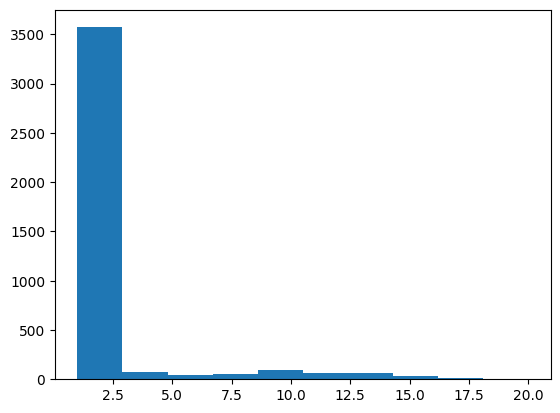

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/API_management.csv"
save_vis = "/content/drive/MyDrive/Research/images/API_management"
data_name = "API_Management"
get_res(path, save_vis, data_name)

## Version2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/API_management.csv"
save_vis = "/content/drive/MyDrive/Research/images/API_management/version2"
data_name = "API_Management"
get_res_test(path, save_vis, data_name, data_name)

There are 383 actions in API_Management
The max number of feature an action posses: 20
The min number of feature an action posses: 1
##############################
Created feature network
##############################
There are 248 disjoint/ connected components in feature network
##############################
10 most important features
API Guidelines linter - beta 0.0048543689320388345
Speech to Text OpenAI Whisper 0.0048543689320388345
Setup specmatic environment 0.0048543689320388345
octodns-sync_ 0.004623208506703652
OPTIMADE validator 0.004623208506703652
crowdin-request-action 0.004623208506703652
Traffic to Badge 0.004623208506703652
oction-create-deployment-status 0.004392048081368469
ServiceNow DevOps Change Update 0.004392048081368469
Silverstripe Cloud Dashboard API Service 0.004392048081368469
##############################
distribution of degrees
##############################
All nodes are unique: True
There are 235 Atomic Actions.
##############################
adding 

# CI

## version1

There are 6904 actions in CI
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 2459 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/CI/CI1.html
Saved pvis visualization 1
##############################
10 most important features
personal access token 0.0018443893366398016
comma separated list 0.001379417234965902
access key id 0.0009454432734035958
base sixty-four encoded 0.0008834469931804092
secret access key 0.0008524488530688159
github action workflow 0.0007749535027898327
github access token 0.0007284562926224426
 one hundred 0.0006819590824550527
pull request number 0.0006199628022318661
 two hundred 0.0005889646621202728
##############################
distribution of degrees
##############################
The nodes are unique: True
There are 13885  nodes with degree 2 or 

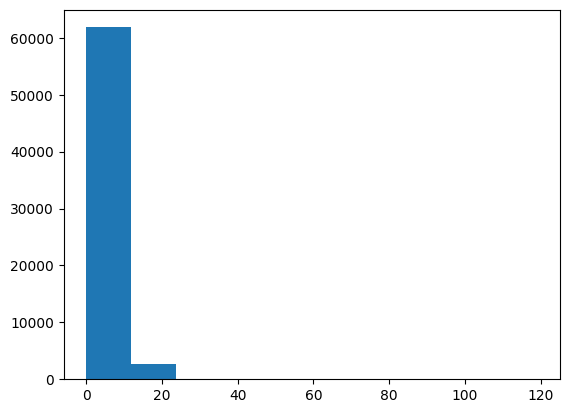

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Continuous_integration.csv"
save_vis = "/content/drive/MyDrive/Research/images/CI"
data_name = "CI"
get_res(path, save_vis, data_name)

## Version2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Continuous_integration.csv"
save_vis = "/content/drive/MyDrive/Research/images/CI/version2"
data_name = "CI"
get_res_test(path, save_vis, data_name, data_name)

There are 6904 actions in CI
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 1756 disjoint/ connected components in feature network
##############################
10 most important features
personal access token 0.0017089352902317835
comma separated list 0.001278111267484275
access key id 0.0008760088462532671
base sixty-four encoded 0.0008185656432202659
secret access key 0.0007898440417037655
github action workflow 0.000718040037912514
github access token 0.0006749576356377632
 one hundred 0.0006318752333630123
pull request number 0.0005744320303300112
 two hundred 0.0005457104288135107
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  28
number of features with degree 1 or higher:  54752
There are 2066 Atomic Actions.
#####################

# Chat

## version 1

There are 384 actions in Chat
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 194 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/chat/Chat1.html
Saved pvis visualization 1
##############################
10 most important features
Slack workflow start/finish messaging 0.005496015388843089
Wecom Notification Action 0.005496015388843089
Speech to Text OpenAI Whisper 0.005496015388843089
Smart Telegram Action 0.005221214619400934
Twilio SMS 0.00494641384995878
Discord Reporter 0.00494641384995878
PR Monitor 0.00494641384995878
Composite Discord Webhooks 0.00494641384995878
Send Tweet v2 0.00494641384995878
Guestbook Workflow 0.00494641384995878
##############################
distribution of degrees
##############################
The nodes are unique: True
There are 720  nodes wit

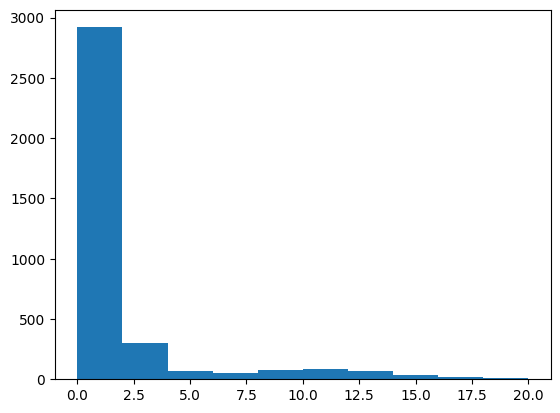

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Chat.csv"
save_vis = "/content/drive/MyDrive/Research/images/chat"
data_name = "Chat"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Chat.csv"
save_vis = "/content/drive/MyDrive/Research/images/chat/version2"
data_name = "Chat"
get_res_test(path, save_vis, data_name, data_name)

There are 384 actions in Chat
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 178 disjoint/ connected components in feature network
##############################
10 most important features
Slack workflow start/finish messaging 0.005255255255255255
Wecom Notification Action 0.005255255255255255
Speech to Text OpenAI Whisper 0.005255255255255255
Smart Telegram Action 0.005005005005005005
Twilio SMS 0.004754754754754755
Discord Reporter 0.004754754754754755
PR Monitor 0.004754754754754755
Composite Discord Webhooks 0.004754754754754755
Send Tweet v2 0.004754754754754755
Guestbook Workflow 0.004754754754754755
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  2
number of features with degree 1 or higher:  3254
There are 163 Atomic Actions.
#####

# code quality

## version 1

There are 1709 actions in code_quality
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 810 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/code_quality/code_quality1.html
Saved pvis visualization 1
##############################
10 most important features
found truefalsendefault falsen 0.0036734435366394323
error found truefalsendefault 0.0035467730698587625
pull request impullrequestove 0.003420102603078092
review experience githubtoken 0.0030400912027360822
addeddiffcontextfilenofilterndefault addedn exit 0.002976755969345747
truefalsendefault falsen additional 0.0021533979352713916
githubtoken report level 0.001963392235100386
comma separated list 0.0015200456013680411
tool name use 0.001456710367977706
comment pull request 0.0013933751345873708
############################

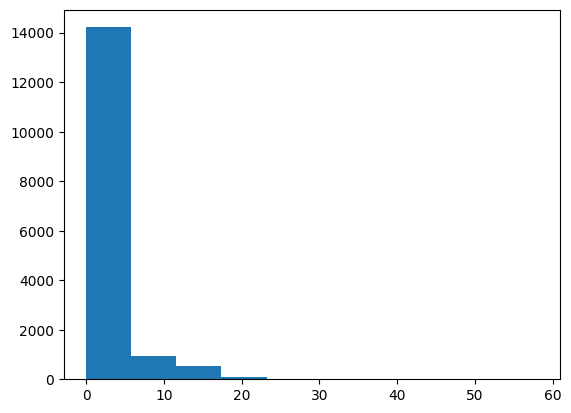

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Code_quality.csv"
save_vis = "/content/drive/MyDrive/Research/images/code_quality"
data_name = "code_quality"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Code_quality.csv"
save_vis = "/content/drive/MyDrive/Research/images/code_quality/version2"
data_name = "code_quality"
get_res_test(path, save_vis, data_name, data_name)

There are 1709 actions in code_quality
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 670 disjoint/ connected components in feature network
##############################
10 most important features
found truefalsendefault falsen 0.0033762151463996738
error found truefalsendefault 0.0032597939344548577
pull request impullrequestove 0.003143372722510041
review experience githubtoken 0.0027941090866755924
addeddiffcontextfilenofilterndefault addedn exit 0.002735898480703184
truefalsendefault falsen additional 0.001979160603061878
githubtoken report level 0.0018045287851446532
reviewdog 0.0016881075731998369
comma separated list 0.0013970545433377962
tool name use 0.001338843937365388
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  7
number of

# Code review

## version 1

There are 1473 actions in code_review
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 615 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/code_review/code_review1.html
Saved pvis visualization 1
##############################
10 most important features
found truefalsendefault falsen 0.004034328467688697
pull request impullrequestove 0.004034328467688697
error found truefalsendefault 0.0038876256143181988
review experience githubtoken 0.0035208684808919538
addeddiffcontextfilenofilterndefault addedn exit 0.0033741656275214555
truefalsendefault falsen additional 0.002567299933983716
githubtoken report level 0.002200542800557471
comment pull request 0.002053839947186973
pull request github 0.001980488520501724
tool name use 0.001980488520501724
##############################
dist

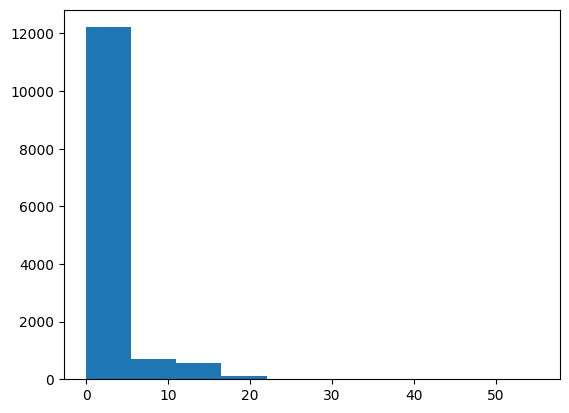

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Code_review.csv"
save_vis = "/content/drive/MyDrive/Research/images/code_review"
data_name = "code_review"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Code_review.csv"
save_vis = "/content/drive/MyDrive/Research/images/code_review/version2"
data_name = "code_review"
get_res_test(path, save_vis, data_name, data_name)

There are 1473 actions in code_review
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 533 disjoint/ connected components in feature network
##############################
10 most important features
found truefalsendefault falsen 0.003690036900369004
pull request impullrequestove 0.003690036900369004
error found truefalsendefault 0.0035558537403555857
review experience githubtoken 0.00322039584032204
addeddiffcontextfilenofilterndefault addedn exit 0.0030862126803086216
truefalsendefault falsen additional 0.002348205300234821
githubtoken report level 0.002012747400201275
reviewdog 0.0019456558201945658
comment pull request 0.0018785642401878567
pull request github 0.0018114726601811473
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  5
number

# dependency manger

## version 1

There are 961 actions in Dependecy_management
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 543 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Dependecy_management/Dependecy_management1.html
Saved pvis visualization 1
##############################
10 most important features
personal access token 0.002932551319648094
Setup Poetry environment 0.0020946795140343527
Snowfall Thaw 0.0020946795140343527
license-compliance 0.0020946795140343527
Nix Quick Install (devholic/test) 0.0020946795140343527
Nix Quick Install 0.0020946795140343527
codenotary immutable ledger 0.0020946795140343527
us vcn tool 0.0020946795140343527
vcn tool codenotarycom 0.0020946795140343527
bill material bom 0.0020946795140343527
##############################
distribution of degrees
#####################

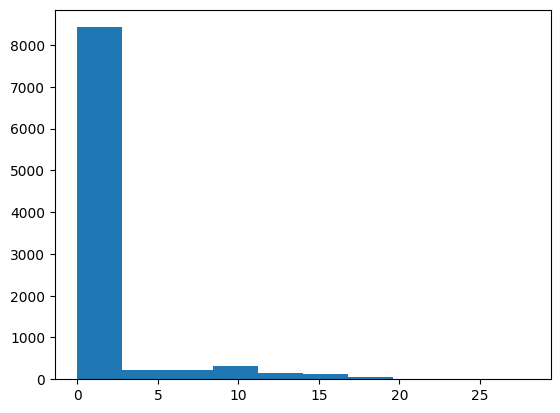

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Dependency_management.csv"
save_vis = "/content/drive/MyDrive/Research/images/Dependecy_management"
data_name = "Dependecy_management"
get_res(path, save_vis, data_name)

## version2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Dependency_management.csv"
save_vis = "/content/drive/MyDrive/Research/images/Dependecy_management/version2"
data_name = "Dependecy_management"
get_res_test(path, save_vis, data_name, data_name)

There are 961 actions in Dependecy_management
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 478 disjoint/ connected components in feature network
##############################
10 most important features
personal access token 0.002700617283950617
Setup Poetry environment 0.002025462962962963
codenotary 0.002025462962962963
Snowfall Thaw 0.002025462962962963
license-compliance 0.002025462962962963
Nix Quick Install (devholic/test) 0.002025462962962963
Nix Quick Install 0.002025462962962963
Install PHP Dependencies with Composer 0.002025462962962963
Setup Cpp (C++ / C) 0.002025462962962963
Compile Minecraft Spigot (via BuildTools) 0.002025462962962963
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  1
number of features with degree 1 or high

# deployment

## version1

There are 4027 actions in Deployment
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 1406 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Deployment/Deployment1.html
Saved pvis visualization 1
##############################
10 most important features
utf sixteen utf 0.0016734594725903533
access key id 0.00164646819077438
unlock paid capability 0.00164646819077438
personal access token 0.00164646819077438
secret access key 0.0015924856271424329
sixteen utf sixteen 0.0015924856271424329
capability get free 0.0015924856271424329
get free trial 0.0015654943453264594
paid capability get 0.0015654943453264594
throw exception missing 0.0015654943453264594
##############################
distribution of degrees
##############################
The nodes are unique: True
There are 8201  n

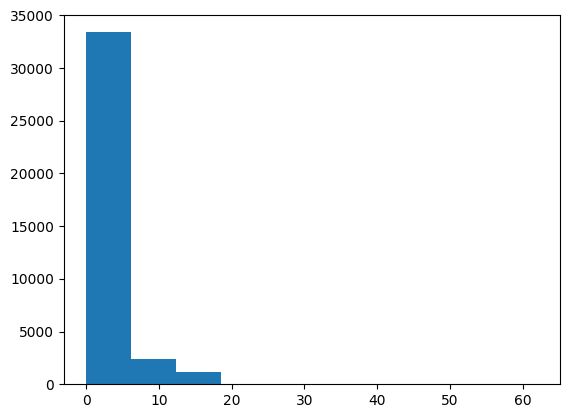

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Deployment.csv"
save_vis = "/content/drive/MyDrive/Research/images/Deployment"
data_name = "Deployment"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Deployment.csv"
save_vis = "/content/drive/MyDrive/Research/images/Deployment/version2"
data_name = "Deployment"
get_res_test(path, save_vis, data_name, "Deployment")

There are 4027 actions in Deployment
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 1119 disjoint/ connected components in feature network
##############################
10 most important features
liquibase-github-actions 0.0015393400700151453
utf sixteen utf 0.0015393400700151453
access key id 0.0015145120043697396
unlock paid capability 0.0015145120043697396
personal access token 0.0015145120043697396
secret access key 0.0014648558730789285
sixteen utf sixteen 0.0014648558730789285
capability get free 0.0014648558730789285
get free trial 0.001440027807433523
paid capability get 0.001440027807433523
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  13
number of features with degree 1 or higher:  31622
There are 1189 Atomic Actions.
########

## developing version 2method

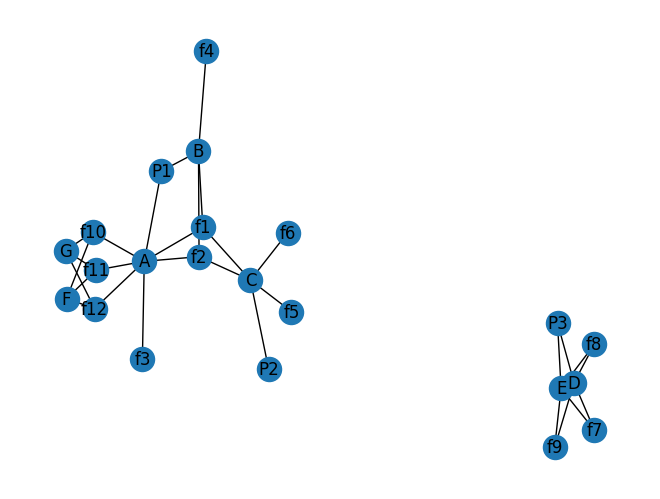

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an empty graph
G = nx.Graph()



# Add edges
G.add_edge("A", "P1")
G.add_edge("P1", "B")
G.add_edge("C", "P2")
G.add_edge("A", "f1")
G.add_edge("f2", "A")
G.add_edge("A", "f3")
G.add_edge("B", "f1")
G.add_edge("f2", "B")
G.add_edge("f4", "B")
G.add_edge("C", "f1")
G.add_edge("f2", "C")
G.add_edge("f5", "C")
G.add_edge("f6", "C")
G.add_edge("f10", "F")
G.add_edge("f10", "A")
G.add_edge("f10", "G")
G.add_edge("f11", "F")
G.add_edge("f11", "A")
G.add_edge("f11", "G")
G.add_edge("f12", "G")
G.add_edge("f12", "A")
G.add_edge("f12", "F")

G.add_edge("f7", "D")
G.add_edge("f8", "D")
G.add_edge("f9", "D")
G.add_edge("P3", "D")
G.add_edge("f7", "E")
G.add_edge("f8", "E")
G.add_edge("f9", "E")
G.add_edge("P3", "E")
# Draw the network
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
def make_pairs(lst):
    pairs = []
    for i in range(len(lst)):
        for j in range(i + 1, len(lst)):
            pairs.append([lst[i], lst[j]])
    return pairs

def check_subset(list1, list2):
    set1 = set(list1)
    set2 = set(list2)
    return set1.issubset(set2)

def check_value_not_in_list_of_dicts(lst, key, value):
    for dictionary in lst:
        if key in dictionary and dictionary[key] == value:
            return False
    return True

def simplify_list(lst):
    simplified = []
    for sublist in lst:
        found = False
        for s in simplified:
            if any(item in s for item in sublist):
                s.extend(item for item in sublist if item not in s)
                found = True
                break
        if not found:
            simplified.append(sublist)
    return simplified

In [ ]:
all = [(node, degree) for node, degree in dict(G.degree()).items() if degree >= 0] # list of tuple of node, degree
temp_degree2 = pd.DataFrame(all, columns=['nodes', 'Degree'])
nodes = list(temp_degree2["nodes"]); publisher_list = ["P1", "P2", "P3"]
actions = ["A", "B", "C", "D", "E", "G"];
publishers= []; action_list = []; feature_list = []
for n in nodes:
    if n in publisher_list:
      publishers.append(n)
    elif n in actions: action_list.append(n)
    else: feature_list.append(n)

disjoint_components = list(nx.connected_components(G))
features_that_come_together = []
for component in disjoint_components:
  subgraph = G.subgraph(component)
  edges = list(subgraph.edges())
  edges_action_feature = []
  for e in edges:
      if e[0] not in publishers and e[1] not in publishers:
        edges_action_feature.append(e)
  component_action_list = []; component_feature_list=[]
  for e in edges_action_feature:
    if e[0] in action_list and e[0] not in component_action_list: component_action_list.append(e[0])
    if e[1] in action_list and e[1] not in component_action_list: component_action_list.append(e[1])
    if e[0] not in action_list and e[0] not in component_feature_list: component_feature_list.append(e[0])
    if e[1] not in action_list and e[1] not in component_feature_list: component_feature_list.append(e[1])
  feature_count_action_list = []; action_added=[]
  for action in component_action_list:
    if action not in action_added:
      features = []
      for e in edges_action_feature:
        if e[0] == action and e[1] not in features:
          features.append(e[1])
        if e[1] == action and e[0] not in features:
          features.append(e[0])
      feature_count_action_list.append({"action": action, "features":features })
      action_added.append(action)
  # find features that come together
  features_pair_come_together = []; action_added=[]
  pairs = make_pairs(component_feature_list)
  for pair in pairs:
    count = 0;
    for elm in feature_count_action_list:
      feature = elm["features"]
      isSubset = check_subset(pair, feature)
      if isSubset: count += 1
    if count >= 2:
      features_pair_come_together.append(pair)
  consolidate_list = simplify_list(features_pair_come_together)
  features_that_come_together.extend(consolidate_list)

print("Features that happen together in this network: "+str(features_that_come_together))

size_counts = {}

for sublist in features_that_come_together:
    size = len(sublist)
    if size in size_counts:
        size_counts[size] += 1
    else:
        size_counts[size] = 1

print("possible tuple sizes for features that happen together:", len(size_counts))
print("Different sizes and their counts:")
for size, count in size_counts.items():
    print("Size:", size, "- Count:", count, "| There are " + str(count) + ", " + str(size)+"-tuple feature set that happen together")




Features that happen together in this network: [['f1', 'f2'], ['f10', 'f11', 'f12'], ['f7', 'f8', 'f9']]
possible tuple sizes for features that happen together: 2
Different sizes and their counts:
Size: 2 - Count: 1 | There are 1, 2-tuple feature set that happen together
Size: 3 - Count: 2 | There are 2, 3-tuple feature set that happen together


In [ ]:
nested_list = [['f7', 'f8', "f1"], ['f7', 'f9', "x", "l"], ['f8', 'f9'], ["f2"], [";", "u"]]

size_counts = {}

for sublist in nested_list:
    size = len(sublist)
    if size in size_counts:
        size_counts[size] += 1
    else:
        size_counts[size] = 1

print("Number of different sizes:", len(size_counts))
print("Different sizes and their counts:")
for size, count in size_counts.items():
    print("Size:", size, "- Count:", count)


Number of different sizes: 4
Different sizes and their counts:
Size: 3 - Count: 1
Size: 4 - Count: 1
Size: 2 - Count: 2
Size: 1 - Count: 1


#IDEs

## version 1

There are 39 actions in IDEs
The max number of feature an action posses: 20
The min number of feature an action posses: 6
##############################
Created feature network
##############################
There are 33 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/IDEs/IDEs1.html
Saved pvis visualization 1
##############################
10 most important features
Setup Database Client 0.043478260869565216
Acción de repetición con Docker 0.038901601830663615
IntelliJ Platform Plugin Verifier 0.038901601830663615
Setup Kotlin 0.034324942791762014
Install Clang 0.034324942791762014
Setup WeChat Developer Tools 0.032036613272311214
arm-none-eabi-gcc GNU Arm Embedded Toolchain 0.032036613272311214
Try in Web IDE 0.029748283752860413
setup-msbuild 0.029748283752860413
Build STM32CubeIde project 0.029748283752860413
##############################
distribution of degrees
##############################
The nodes are uni

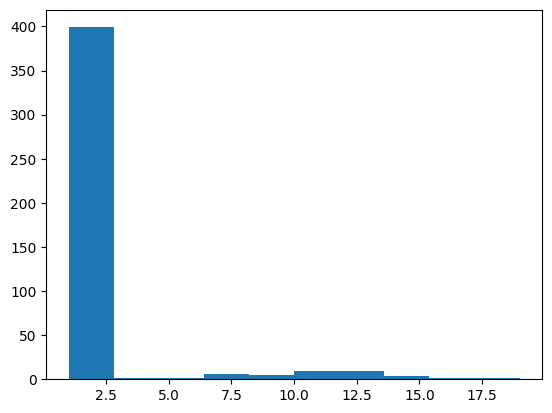

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/IDEs.csv"
save_vis = "/content/drive/MyDrive/Research/images/IDEs"
data_name = "IDEs"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/IDEs.csv"
save_vis = "/content/drive/MyDrive/Research/images/IDEs/version2"
data_name = "IDEs"
get_res_test(path, save_vis, data_name, data_name)

There are 39 actions in IDEs
The max number of feature an action posses: 20
The min number of feature an action posses: 6
##############################
Created feature network
##############################
There are 32 disjoint/ connected components in feature network
##############################
10 most important features
Setup Database Client 0.0423728813559322
Acción de repetición con Docker 0.038135593220338986
IntelliJ Platform Plugin Verifier 0.038135593220338986
Setup Kotlin 0.03389830508474576
Install Clang 0.03389830508474576
Setup WeChat Developer Tools 0.03177966101694915
arm-none-eabi-gcc GNU Arm Embedded Toolchain 0.03177966101694915
Try in Web IDE 0.029661016949152543
setup-msbuild 0.029661016949152543
Build STM32CubeIde project 0.029661016949152543
##############################
distribution of degrees
##############################
All nodes are unique: True
There are 29 Atomic Actions.
##############################
adding publisher to atomic network
Finished addin

#learning

## version 1

There are 162 actions in Learning
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 117 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Learning/Learning1.html
Saved pvis visualization 1
##############################
10 most important features
someone record time 0.015942028985507246
record time greet 0.015942028985507246
greet someone record 0.015217391304347827
greet time greeted 0.015217391304347827
time greet time 0.014492753623188406
try build and test 0.014492753623188406
AI Blog Writer 0.013768115942028985
golang Actionsszdxfcgv 0.013043478260869566
Cortx PR checklist 0.012318840579710146
Setup Processing 0.012318840579710146
##############################
distribution of degrees
##############################
The nodes are unique: True
There are 219  nodes with degree 2

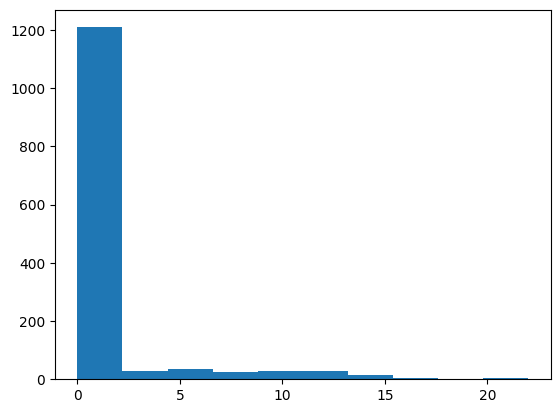

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Learning.csv"
save_vis = "/content/drive/MyDrive/Research/images/Learning"
data_name = "Learning"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Learning.csv"
save_vis = "/content/drive/MyDrive/Research/images/Learning/version2"
data_name = "Learning"
get_res_test(path, save_vis, data_name, data_name)

There are 162 actions in Learning
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 109 disjoint/ connected components in feature network
##############################
10 most important features
someone record time 0.01437908496732026
record time greet 0.01437908496732026
greet someone record 0.013725490196078431
greet time greeted 0.013725490196078431
try build and test 0.013725490196078431
time greet time 0.0130718954248366
AI Blog Writer 0.0130718954248366
golang Actionsszdxfcgv 0.01241830065359477
Cortx PR checklist 0.011764705882352941
Setup Processing 0.011764705882352941
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  3
number of features with degree 1 or higher:  1295
There are 98 Atomic Actions.
##############################
adding

#localization

## version 1

There are 100 actions in Localization
The max number of feature an action posses: 20
The min number of feature an action posses: 1
##############################
Created feature network
##############################
There are 73 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Localization/Localization1.html
Saved pvis visualization 1
##############################
10 most important features
crowdin-request-action 0.018590998043052837
Language Weaver 0.016634050880626222
Actions with HXLTM - terminology, translation & localization 0.016634050880626222
AI Translator Action 0.016634050880626222
action-crowdin-contributors 0.016634050880626222
Actions with extras for HXLTM 0.015655577299412915
locize download 0.015655577299412915
github-transifex-actions 0.015655577299412915
i18next resources validator 0.015655577299412915
OpenAI Continuous Translation Action 0.015655577299412915
##############################
distrib

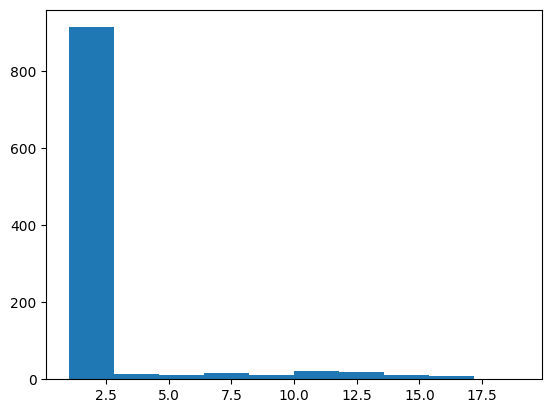

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Localization.csv"
save_vis = "/content/drive/MyDrive/Research/images/Localization"
data_name = "Localization"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Localization.csv"
save_vis = "/content/drive/MyDrive/Research/images/Localization/version2"
data_name = "Localization"
get_res_test(path, save_vis, data_name, data_name)

There are 100 actions in Localization
The max number of feature an action posses: 20
The min number of feature an action posses: 1
##############################
Created feature network
##############################
There are 68 disjoint/ connected components in feature network
##############################
10 most important features
crowdin-request-action 0.018034265103697024
Language Weaver 0.016230838593327322
Actions with HXLTM - terminology, translation & localization 0.016230838593327322
AI Translator Action 0.016230838593327322
action-crowdin-contributors 0.016230838593327322
Actions with extras for HXLTM 0.01532912533814247
locize download 0.01532912533814247
github-transifex-actions 0.01532912533814247
i18next resources validator 0.01532912533814247
OpenAI Continuous Translation Action 0.01532912533814247
##############################
distribution of degrees
##############################
All nodes are unique: True
There are 59 Atomic Actions.
##############################

#Mobile

## version 1

There are 127 actions in Mobile
The max number of feature an action posses: 20
The min number of feature an action posses: 1
##############################
Created feature network
##############################
There are 72 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Mobile/Mobile1.html
Saved pvis visualization 1
##############################
10 most important features
Sms77.io SMS 0.014728682170542635
This action uploads an application file to DeployGate 0.013953488372093023
Firebase Increment App Version 0.013953488372093023
Sourcetoad - Tizen Build 0.013953488372093023
iOS Build/Release Action 0.01317829457364341
.NET MAUI - Apple Provisioning 0.01317829457364341
iOS Bump Version 0.01317829457364341
Trigger Mobile Builds with Appflow 0.012403100775193798
Genymotion SaaS Action 0.012403100775193798
Obvious - iOS Build Action 0.012403100775193798
##############################
distribution of degrees
########

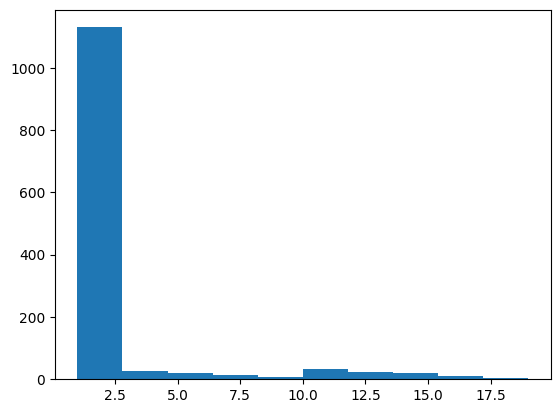

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Mobile.csv"
save_vis = "/content/drive/MyDrive/Research/images/Mobile"
data_name = "Mobile"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Mobile.csv"
save_vis = "/content/drive/MyDrive/Research/images/Mobile/version2"
data_name = "Mobile"
get_res_test(path, save_vis, data_name, data_name)

There are 127 actions in Mobile
The max number of feature an action posses: 20
The min number of feature an action posses: 1
##############################
Created feature network
##############################
There are 67 disjoint/ connected components in feature network
##############################
10 most important features
Sms77.io SMS 0.014295925661186561
This action uploads an application file to DeployGate 0.013581129378127233
Firebase Increment App Version 0.013581129378127233
Sourcetoad - Tizen Build 0.013581129378127233
iOS Build/Release Action 0.012866333095067906
.NET MAUI - Apple Provisioning 0.012866333095067906
iOS Bump Version 0.012866333095067906
Trigger Mobile Builds with Appflow 0.012151536812008578
Genymotion SaaS Action 0.012151536812008578
Obvious - iOS Build Action 0.012151536812008578
##############################
distribution of degrees
##############################
All nodes are unique: True
There are 55 Atomic Actions.
##############################
addi

# Monitoring

## version 1

There are 404 actions in Monitoring
The max number of feature an action posses: 20
The min number of feature an action posses: 3
##############################
Created feature network
##############################
There are 282 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Monitoring/Monitoring1.html
Saved pvis visualization 1
##############################
10 most important features
Yor GitHub Action 0.004472271914132379
Platform.sh Deploy status 0.004472271914132379
HTTP(s) URL health check and TLS/SSL certification expiry check 0.004472271914132379
Should I notify slack? 0.004472271914132379
Ember Asset Size 0.004472271914132379
Bring Your Own Badge 0.004472271914132379
URL Health Check 0.004472271914132379
Server Alert In Telegram 0.00424865831842576
Sentry Release (with custom URL) 0.00424865831842576
wpt unofficial action 0.00424865831842576
##############################
distribution of degrees
##########

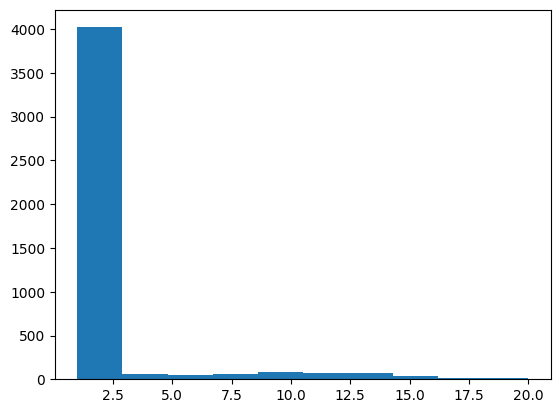

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Monitoring.csv"
save_vis = "/content/drive/MyDrive/Research/images/Monitoring"
data_name = "Monitoring"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Monitoring.csv"
save_vis = "/content/drive/MyDrive/Research/images/Monitoring/version2"
data_name = "Monitoring"
get_res_test(path, save_vis, data_name, data_name)

There are 404 actions in Monitoring
The max number of feature an action posses: 20
The min number of feature an action posses: 3
##############################
Created feature network
##############################
There are 266 disjoint/ connected components in feature network
##############################
10 most important features
Yor GitHub Action 0.0043343653250774
Platform.sh Deploy status 0.0043343653250774
HTTP(s) URL health check and TLS/SSL certification expiry check 0.0043343653250774
Should I notify slack? 0.0043343653250774
Ember Asset Size 0.0043343653250774
Bring Your Own Badge 0.0043343653250774
URL Health Check 0.0043343653250774
Server Alert In Telegram 0.0041279669762641896
Sentry Release (with custom URL) 0.0041279669762641896
wpt unofficial action 0.0041279669762641896
##############################
distribution of degrees
##############################
All nodes are unique: True
There are 239 Atomic Actions.
##############################
adding publisher to atom

# project management

## version1

There are 1136 actions in project_mangement
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 527 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/project_mangement/project_mangement1.html
Saved pvis visualization 1
##############################
10 most important features
personal access token 0.004818221638195357
issue pull request 0.003241349102058695
github access token 0.0018396846254927727
passed using secretsgithubtoken 0.0017520805957074027
PR to notion 0.0017520805957074027
PR Auto-assign 0.0017520805957074027
Github Pull Request 0.0017520805957074027
Auto Pull Request 0.0017520805957074027
OSS Governance Bot 0.0017520805957074027
Automated Flysystem Maintenance 0.0017520805957074027
##############################
distribution of degrees
##############################
Th

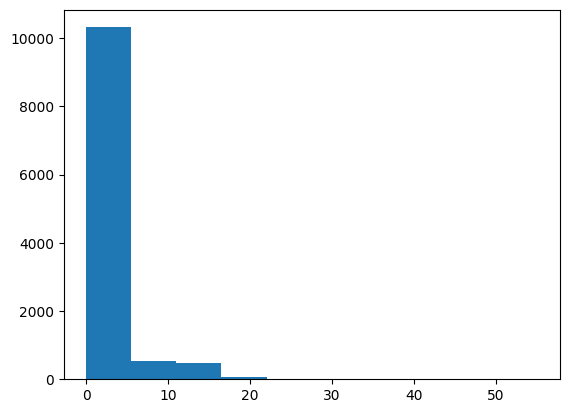

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Project_Management.csv"
save_vis = "/content/drive/MyDrive/Research/images/project_mangement"
data_name = "project_mangement"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Project_Management.csv"
save_vis = "/content/drive/MyDrive/Research/images/project_mangement/version 2"
data_name = "project_mangement"
get_res_test(path, save_vis, data_name, data_name)

There are 1136 actions in project_mangement
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 449 disjoint/ connected components in feature network
##############################
10 most important features
personal access token 0.0044444444444444444
issue pull request 0.00298989898989899
github access token 0.001696969696969697
PR to notion 0.001696969696969697
PR Auto-assign 0.001696969696969697
Github Pull Request 0.001696969696969697
Auto Pull Request 0.001696969696969697
OSS Governance Bot 0.001696969696969697
Automated Flysystem Maintenance 0.001696969696969697
terraform-docs 0.001696969696969697
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  1
number of features with degree 1 or higher:  10263
There are 466 Atomic Actions.
############

# publishing

## version1

There are 2233 actions in publishing
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 1032 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/publishing/publishing1.html
Saved pvis visualization 1
##############################
10 most important features
personal access token 0.0022993688007213707
base sixty-four encoded 0.0011722272317403065
comma separated list 0.0009467989179440938
navigate order view 0.0009467989179440938
Setup LocalStack 0.0009017132551848512
Create GitHub API Deployment 0.0009017132551848512
OGImage 0.0009017132551848512
cpenv Publish Module 0.0009017132551848512
Generate GoDoc HTML files 0.0009017132551848512
action-miniprogram-ci 0.0009017132551848512
##############################
distribution of degrees
##############################
The nodes are unique

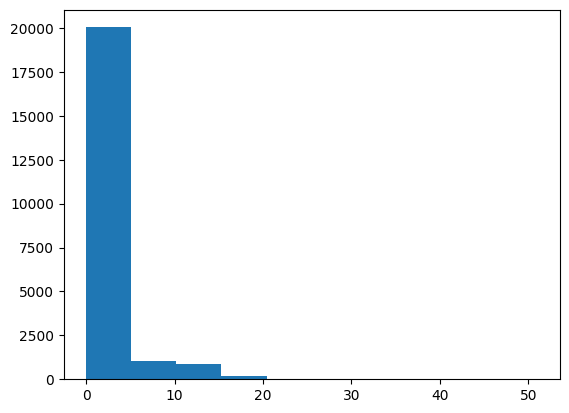

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Publishing.csv"
save_vis = "/content/drive/MyDrive/Research/images/publishing"
data_name = "publishing"
get_res(path, save_vis, data_name)

## version2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Publishing.csv"
save_vis = "/content/drive/MyDrive/Research/images/publishing/version2"
data_name = "publishing"
get_res_test(path, save_vis, data_name, data_name)

There are 2233 actions in publishing
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 883 disjoint/ connected components in feature network
##############################
10 most important features
personal access token 0.002115480338476854
base sixty-four encoded 0.0010784801725568277
Setup LocalStack 0.0008710801393728223
comma separated list 0.0008710801393728223
navigate order view 0.0008710801393728223
Create GitHub API Deployment 0.0008710801393728223
OGImage 0.0008710801393728223
cpenv Publish Module 0.0008710801393728223
Generate GoDoc HTML files 0.0008710801393728223
action-miniprogram-ci 0.0008710801393728223
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  5
number of features with degree 1 or higher:  19647
There are 864 Atomic Ac

# Security

## version1

There are 1110 actions in Security
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 575 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Security/Security1.html
Saved pvis visualization 1
##############################
10 most important features
personal access token 0.0027392418485464344
comma separated list 0.002209066006892286
securely install latest 0.0018556154457895202
Orca Security - IaC Security 0.0017672528055138288
Teleport Auth 0.0017672528055138288
Python Lint Code Scanning Action 0.0017672528055138288
tfsec action 0.0017672528055138288
Zimperium zScan 0.0017672528055138288
InferSharp 0.0017672528055138288
codenotary immutable ledger 0.0017672528055138288
##############################
distribution of degrees
##############################
The nodes are unique: True


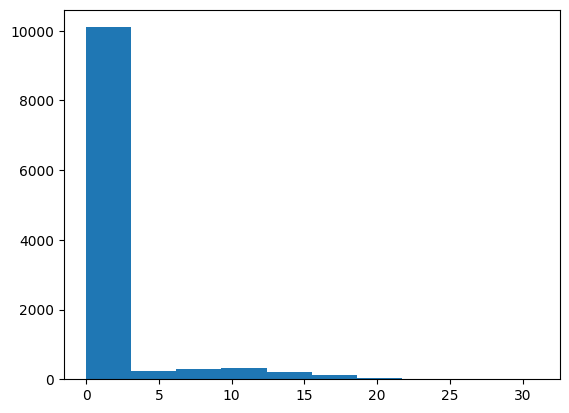

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Security.csv"
save_vis = "/content/drive/MyDrive/Research/images/Security"
data_name = "Security"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Security.csv"
save_vis = "/content/drive/MyDrive/Research/images/Security/version2"
data_name = "Security"
get_res_test(path, save_vis, data_name, data_name)

There are 1110 actions in Security
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 465 disjoint/ connected components in feature network
##############################
10 most important features
personal access token 0.0025508104994651525
comma separated list 0.0020571052415041553
codenotary 0.001974821031843989
Orca Security - IaC Security 0.0017279684028634905
Teleport Auth 0.0017279684028634905
Python Lint Code Scanning Action 0.0017279684028634905
tfsec action 0.0017279684028634905
Zimperium zScan 0.0017279684028634905
InferSharp 0.0017279684028634905
Kiuwan Delivery Analysis 0.0017279684028634905
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  2
number of features with degree 1 or higher:  9935
There are 468 Atomic Actions.
###########

#support

## version 1

There are 286 actions in Support
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 218 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Support/Support1.html
Saved pvis visualization 1
##############################
10 most important features
Needs More Info 0.0067613252197430695
Protobuffer Compile Action 0.0067613252197430695
Workflow Manager 0.0067613252197430695
Trigger Test on TestIO 0.0067613252197430695
Priority List 0.006423258958755916
GitHub Actions documenter 0.006423258958755916
dnx-terraform-docs 0.006423258958755916
SourceMod Cvar Docs 0.006423258958755916
Run textlint with reviewdog 0.006423258958755916
DynamoDB Actions 0.006085192697768763
##############################
distribution of degrees
##############################
The nodes are unique: True
There are 381

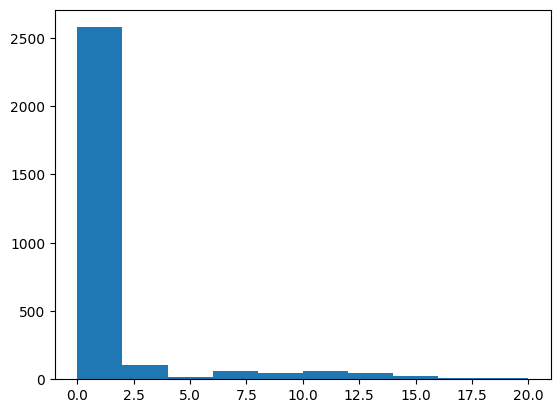

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Support.csv"
save_vis = "/content/drive/MyDrive/Research/images/Support"
data_name = "Support"
get_res(path, save_vis, data_name)

## version2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Support.csv"
save_vis = "/content/drive/MyDrive/Research/images/Support/version2"
data_name = "Support"
get_res_test(path, save_vis, data_name, data_name)

There are 286 actions in Support
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 190 disjoint/ connected components in feature network
##############################
10 most important features
Needs More Info 0.0065625
Protobuffer Compile Action 0.0065625
Workflow Manager 0.0065625
Trigger Test on TestIO 0.0065625
Priority List 0.00625
GitHub Actions documenter 0.00625
dnx-terraform-docs 0.00625
SourceMod Cvar Docs 0.00625
Run textlint with reviewdog 0.00625
DynamoDB Actions 0.0059375
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  2
number of features with degree 1 or higher:  2794
There are 184 Atomic Actions.
##############################
adding publisher to atomic network
Finished adding publishers
##############################
There 

# Testing

## version 1

There are 1495 actions in Testing
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 851 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Testing/Testing1.html
Saved pvis visualization 1
##############################
10 most important features
utf sixteen utf 0.004591167468299082
unlock paid capability 0.004518291794199096
sixteen utf sixteen 0.004372540445999125
capability get free 0.004372540445999125
get free trial 0.00429966477189914
paid capability get 0.00429966477189914
throw exception missing 0.00429966477189914
argument supercedes whatever 0.00429966477189914
generated argument supercedes 0.004226789097799154
greet someone record 0.002113394548899577
##############################
distribution of degrees
##############################
The nodes are unique: True
There are

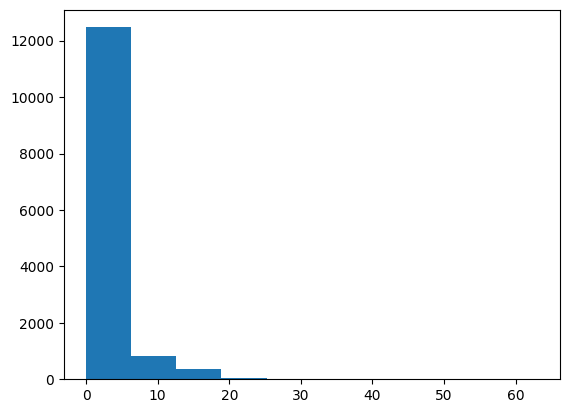

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Testing.csv"
save_vis = "/content/drive/MyDrive/Research/images/Testing"
data_name = "Testing"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Testing.csv"
save_vis = "/content/drive/MyDrive/Research/images/Testing/version2"
data_name = "Testing"
get_res_test(path, save_vis, data_name, data_name)

There are 1495 actions in Testing
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 732 disjoint/ connected components in feature network
##############################
10 most important features
liquibase-github-actions 0.004226202455222379
utf sixteen utf 0.004226202455222379
unlock paid capability 0.004159119876568055
sixteen utf sixteen 0.004024954719259409
capability get free 0.004024954719259409
get free trial 0.003957872140605085
paid capability get 0.003957872140605085
throw exception missing 0.003957872140605085
argument supercedes whatever 0.003957872140605085
generated argument supercedes 0.003890789561950762
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  12
number of features with degree 1 or higher:  12154
There are 715 Atomic A

# Utilities

## version 1

There are 5977 actions in Utilities
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 2408 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/Utilities/Utilities1.html
Saved pvis visualization 1
##############################
10 most important features
personal access token 0.0020449537241075365
github access token 0.0010224768620537682
comma separated list 0.001004847950639048
pull request number 0.0009695901278096078
issue pull request 0.0007756721022476863
pull request github 0.0006522697223446453
github action workflow 0.0006346408109299251
openai api key 0.0005993829881004848
access token repo 0.0005817540766857647
github token used 0.0005464962538563244
##############################
distribution of degrees
##############################
The nodes are unique: True
There are 1

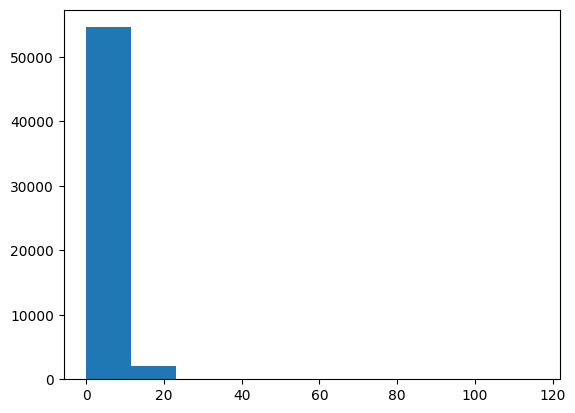

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Utilities.csv"
save_vis = "/content/drive/MyDrive/Research/images/Utilities"
data_name = "Utilities"
get_res(path, save_vis, data_name)

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Utilities.csv"
save_vis = "/content/drive/MyDrive/Research/images/Utilities/version2"
data_name = "Utilities"
get_res_test(path, save_vis, data_name, data_name)

There are 5977 actions in Utilities
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 1722 disjoint/ connected components in feature network
##############################
10 most important features
personal access token 0.0018934447636458607
github access token 0.0009467223818229304
comma separated list 0.0009303995821363281
pull request number 0.0008977539827631235
issue pull request 0.0007182031862104989
pull request github 0.0006039435884042831
github action workflow 0.0005876207887176809
openai api key 0.0005549751893444764
access token repo 0.0005386523896578741
github token used 0.0005060067902846697
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  19
number of features with degree 1 or higher:  49641
There are 2065 Atomic Actions.
####

# all datasets

## version 1

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Actions_dataset.csv"
save_vis = "/content/drive/MyDrive/Research/images/all"
data_name = "All_dataset"
get_res(path, save_vis, data_name)

There are 18280 actions in All_dataset
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 4791 disjoint/ connected components in feature network
##############################
/content/drive/MyDrive/Research/images/all/All_dataset1.html
Saved pvis visualization 1
##############################
10 most important features
personal access token 0.0021501819384717167
comma separated list 0.0013295503702384285
github access token 0.0009096923585841879
pull request number 0.0007633782030077101
github action workflow 0.0007506552329575816
base sixty-four encoded 0.0007379322629074531
access key id 0.0006615944426066821
secret access key 0.0006361485025064252
pull request github 0.0006234255324562967
comment pull request 0.000585256622305911
##############################
distribution of degrees
##############################
The nodes are unique: True
There

## version 2

In [ ]:
path = "/content/drive/MyDrive/Research/EVENTS/dataset_with_features/Actions_dataset.csv"
save_vis = "/content/drive/MyDrive/Research/images/all/version2"
data_name = "All_dataset"
get_res_test(path, save_vis, data_name, data_name)

There are 18280 actions in All_dataset
The max number of feature an action posses: 20
The min number of feature an action posses: 0
##############################
Created feature network
##############################
There are 2916 disjoint/ connected components in feature network
##############################
10 most important features
personal access token 0.0019913629052688638
comma separated list 0.001231345701778676
github access token 0.0008424996906906731
pull request number 0.0007069927474327326
github action workflow 0.0006952095349755204
base sixty-four encoded 0.0006834263225183082
access key id 0.000612727047775035
secret access key 0.0005891606228606106
pull request github 0.0005773774104033983
comment pull request 0.0005420277730317617
##############################
distribution of degrees
##############################
All nodes are unique: True
number of actions with degree 1 or higher:  65
number of features with degree 1 or higher:  128601
There are 4073 Atomic Acti